<a href="https://colab.research.google.com/github/wondercha/DL_experiments/blob/main/RNN_name_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
cd /content/drive/MyDrive/ML study

/content/drive/MyDrive/ML study


In [10]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names/Arabic.txt', 'data/names/English.txt', 'data/names/Dutch.txt', 'data/names/Greek.txt', 'data/names/Polish.txt', 'data/names/Irish.txt', 'data/names/Scottish.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/German.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Japanese.txt', 'data/names/Spanish.txt', 'data/names/Korean.txt', 'data/names/Vietnamese.txt']


In [13]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print("n_letters: ", n_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

n_letters:  57


In [14]:
# Turning names into tensors
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [15]:
# Creating the network
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        # Linear layer 선언
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined) #input
        output = self.i2o(combined) #input
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


In [16]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print('input size:', input.size())
print('output:', output.size())
print('hidden:', next_hidden.size())

input size: torch.Size([6, 1, 57])
output: torch.Size([1, 18])
hidden: torch.Size([1, 128])


In [21]:
# Training
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()
    #print('category_tensor:', category_tensor, line_tensor.size()[0])
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

('Dutch', 2)
category = French / line = Oliver
category = Irish / line = Nevin
category = French / line = Bonner
category = Korean / line = Sun
category = Portuguese / line = Rios
category = Portuguese / line = Santana
category = Vietnamese / line = Thao
category = Dutch / line = Seghers
category = Irish / line = Cuidightheach
category = Vietnamese / line = Trinh


In [24]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    #print(line, line_tensor.size()[0])
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


5000 5% (0m 4s) 2.6457 Uerling / Polish ✗ (Czech)
10000 10% (0m 9s) 2.2441 Ventura / Spanish ✗ (Portuguese)
15000 15% (0m 14s) 3.2762 Homar / Arabic ✗ (Russian)
20000 20% (0m 19s) 3.2983 Yatzun / Arabic ✗ (Russian)
25000 25% (0m 23s) 1.4133 Paszek / Polish ✓
30000 30% (0m 28s) 0.6073 Han / Chinese ✓
35000 35% (0m 33s) 2.1446 Loewe / Dutch ✗ (German)
40000 40% (0m 38s) 3.7496 Groos / Greek ✗ (German)
45000 45% (0m 43s) 1.0046 Sam / Korean ✗ (Chinese)
50000 50% (0m 48s) 1.8629 Tickner / German ✗ (English)
55000 55% (0m 53s) 2.9735 Leverenz / Spanish ✗ (German)
60000 60% (0m 57s) 1.1026 Sun / Korean ✗ (Chinese)
65000 65% (1m 2s) 1.1899 Zuraw / Polish ✓
70000 70% (1m 7s) 0.5006 Maessen / Dutch ✓
75000 75% (1m 12s) 0.3982 Haddad / Arabic ✓
80000 80% (1m 17s) 0.3330 Kouretas / Greek ✓
85000 85% (1m 21s) 0.0285 Coghlan / Irish ✓
90000 90% (1m 26s) 0.3834 Quang / Vietnamese ✓
95000 95% (1m 31s) 0.1279 Berti / Italian ✓
100000 100% (1m 36s) 0.1074 Shadid / Arabic ✓


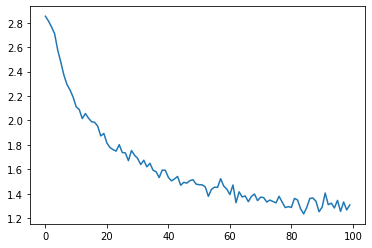

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

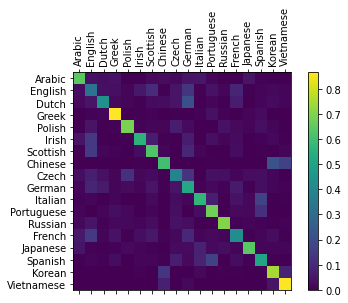

In [27]:
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# Running on User Input
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


In [28]:
predict('Baisotei')
predict('Espinoza')
predict('Shin')


> Baisotei
(-1.12) Spanish
(-1.19) Italian
(-2.34) French

> Espinoza
(-0.84) Spanish
(-1.58) Czech
(-2.39) Russian

> Shin
(-0.63) Korean
(-1.38) Chinese
(-2.49) Irish
